In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 14, 6
import tqdm

import bandits

%load_ext autoreload
%autoreload 2

This post follows Chapter 2 - Multi-armed bandits of [Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) by Sutton & Barto.

The multi-armed bandit is a classic problem in reinforcement learning, and gives a good introduction to the exploration-exploitation dichotomy that crops up in a lot of other places. The framework used is a simplified version of a Markov decision process, where there is only one state and an identical set of available actions at each decision point (more about Markov decision processes in another post). The underlying question for the player is this: how do I use the limited information I have to both expand my knowledge, and maximise my return?

### The multi-armed test bed

<center>
<img src='bandit_arms.svg'></img>
</center>

<center>
Multi-armed bandit, with each machine giving independent rewards
</center>

In this experiment, we consider an __arm__, which when pulled give some reward, which is sampled from some predefined distribution. The name comes from the common _one armed bandit_ gambling games, involving a lever which is pulled to spin the machine and determine the reward (a fruit machine for UK readers). Consider the case of a Gaussian arm, where the reward is sampled from a normal distribution with given mean and standard deviation:

In [2]:
arm = bandits.GaussianArm(5, 3)
arm.pull()

6.777094354209408

Even if we know that the arm gives normally distributed rewards, the parameters of the distribution can only be accurately estimated by performing many pulls of the arm. The task becomes more complicated when multiple arms, each with their own distribution of returns, are combined to form an __arm bed__:

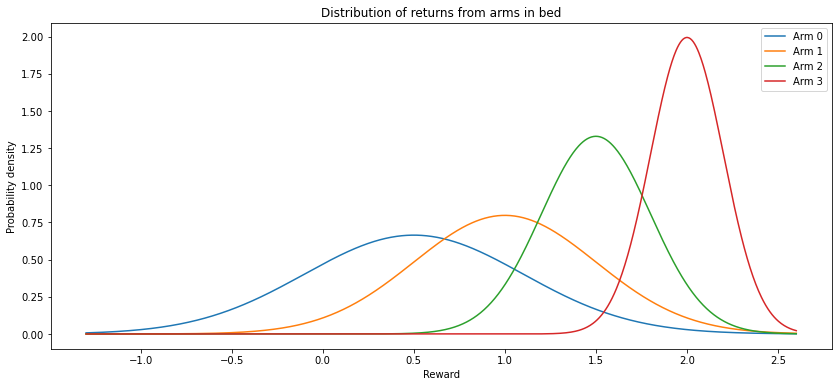

In [3]:
bed = bandits.ArmBed(means=[0.5,1,1.5,2], stds=[0.6, 0.5, 0.3, 0.2])
bed.plot_bed()
plt.savefig('simple_bed.png')

The game is played like this: on each turn, a player (who will be called Alice) gets to choose an arm from the bed to pull, and receives the reward. On the next turn, she can use the information gained from previous pulls to inform the next choice of arm. This then repeats this indefinitely - or, if you prefer, for $N$ turns for some large $N$. Alice's aim is to maximise the cumulative return from the bed (or alternatively, the average return per pull after $N$ turns).

This experiment highlights two competing tactics :
- __Exploration__: Alice will wish to try a variety of different arms, possibly multiple times, in order to gain information about the underlying distributions. This will include arms that she currently views to be suboptimal, on the chance that she was unlucky on previous pulls and the underlying distribution is more favourable than earlier thought.
- __Exploitation__: Once Alice has obtained information indicating that one arm has a more favourable distribution than the others, she will wish to pull this arm as much as possible in order to maximise the reward gained. The more time spent exploring the arms, the less opportunity Alice has to exploit the arms that she thinks are best.

There are many different algorithms for determining what actions Alice should take to maximise her cumulative reward; we consider the following ones:
1. $\varepsilon$-greedy strategy
2. Upper confidence bound (UCB)
3. Gradient bandit

### Setup

First, let's define the game more rigorously. In our case, we have $N$ Gaussian arms, with means $\{\mu_{i}\}_{1\leq i\leq N}$ and unit standard deviations. The arm means are drawn from a standard normal distribution around 0 (so some of the arms can be expected to give negative rewards). At each decision point (i.e. time step $t$), Alice has a choice of action (arm to pull), represented as $A_{t}\in\{1, ..., N\}$. The reward given by this pull is $R_{t}$, which is sampled from the underlying distribution of the chosen arm.

Furthermore, we let:
- $N_{t}(a) = $ the number of times arm $a$ has been pulled up to time $t$
- $Q_{t}(a) = $ the __value function__, giving a perceived value of each arm at time $t$. The value function is used to inform the choice of action - larger value function values indicate a higher value assigned to pulling the relevant arm. The value function will be initialised at the start of the experiment, and updated after each arm pull to reflect the information gained from observing the reward gained. As the number of pulls increases, the value function should approach the true value of pulling the arm - i.e., the expected value of the reward gained by choosing the arm, $E(R_{t}|a)$.

### $\varepsilon$-greedy strategy

As the value function aims to encapsulate the value of pulling each arm, a naive strategy that Alice could follow is to pull the arm which maximises the value function:

$$A_{t}^{naive} = \text{argmax}_{a\in\{1,...,N\}}Q_{t}(a)$$

After the each pull, the value function for the chosen arm $a$ is updated according to the following update rule:

$$Q_{t+1}(a) = Q_{t}(a) + \frac{1}{N_{t}(a)}(R_{t} - Q_{t}(a))$$

It can be shown (e.g. by induction) that the value of $Q_{t}$ for a particular arm $a$ is the sample mean of all rewards obtained from $a$ up to time $t$; as in this case the rewards are normally distributed, the sample mean is the maximum likelihood estimator for $E(R_{t}|a)$, meaning this is a sensible choice of update rule for the value function.

However, this arm selection strategy suffers from a lack of exploration - the current state of the value function may underestimate the value of a particular arm due to some unlucky early pulls, meaning it will never get picked again. To avoid this, we can modify the choice of arm to include a small probability of choosing a random arm:

$$A_{t}^{\varepsilon}=\left\{
                \begin{array}{ll}
                  \text{argmax}_{a\in\{1,...,N\}}Q_{t}(a), & \text{probability}\; 1-\varepsilon\\
                  \text{random }a\in\{1,...,N\},&\text{probability}\; \varepsilon
                \end{array}
              \right.$$

By introducing a small chance of choosing a random arm, given enough time all the arms will be pulled an arbitrarily large number of times. As the number of pulls for each arm goes to infinity, the law of large numbers tells us that the computed value function $Q_{t}(a)$ converges to the true value $E(R_{t}|a)$ - eventually, Alice will have an accurate picture of the value of all the arms and will know exactly which arm to pull with a high certainty. The $\varepsilon$-greedy strategy is not the only strategy that achieves this though and we should expect more sophisticated methods to achieve this convergence faster.

Let's create a class using a $\varepsilon$-greedy strategy to solve the bandit problem:

In [18]:
np.random.seed(8)
bandit = bandits.EpsGreedyBandit(arm_mean=0, arm_std=5, num_arms=10, epsilon=0.1)

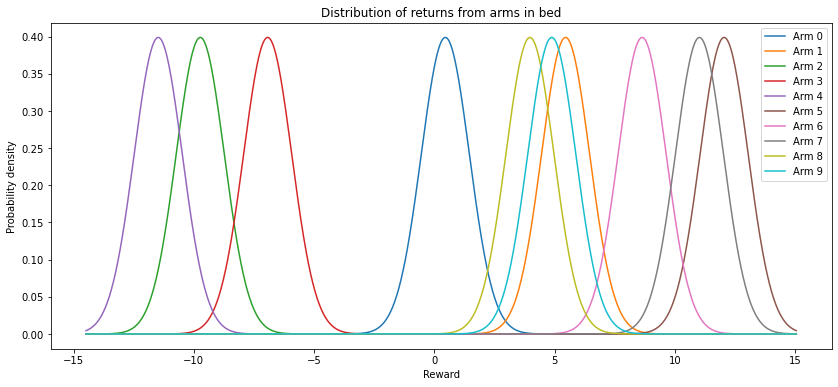

In [19]:
bandit.plot_bed()
plt.savefig('eps_greedy_bed.png')

The `select_arm` method will choose an arm using a $\varepsilon$-greedy strategy, and update the value function and arm pull counts under the hood. Repeating this will give a single simulation of the bandit experiment:

In [20]:
def simulate_bandit(bandit, num_steps):
    rewards = np.zeros(num_steps)
    for step in range(num_steps):
        rewards[step] = bandit.select_arm()
    return rewards

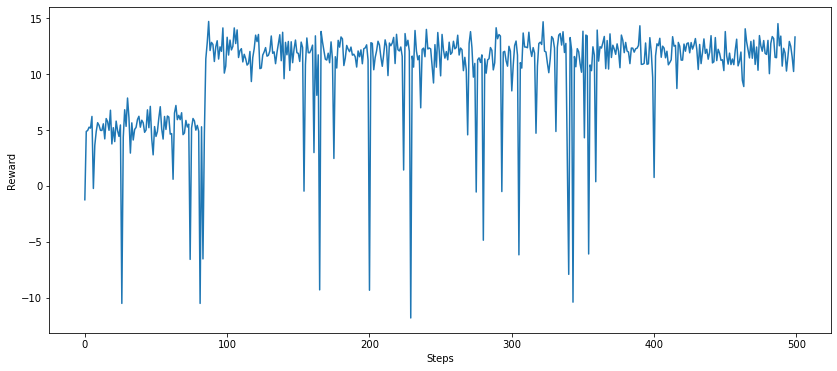

In [21]:
plt.plot(simulate_bandit(bandit, 500))
plt.xlabel('Steps')
plt.ylabel('Reward')
#plt.show()
plt.savefig('eps_greedy_example_run.png')

In this particular simulation, the optimal arm is not discovered until ~90 steps in, when it has been sampled sufficiently via arm exploration. The large downwards spikes are the results of picking a random alternative arm with $\varepsilon$ probability, and will continue as long as the experiment is run, even though it is clear that the optimal arm has been found.

A further observation which improves the initial performance of the $\varepsilon$-greedy strategy is the choice of initialisation for $Q$. If by default all the values are initialised to 0, then we have to wait until each of the arms is chosen by chance (with probability $\varepsilon$) before starting to see accurate value estimates - the exploitation phase is reached too quickly, without sufficient exploration of all of the arms. Instead, consider intialising $Q$ to some large positive value; after each arm is chosen for the first time, the estimate for the value is replaced with the observed reward (this can be seen immediately from the update rule for $Q$), leaving only those arms which are yet to be picked with a large $Q$ value. This ensures that all of the arms are tried at least once before attempting to exploit any information gleaned about the best arm to choose.

In order to eliminate the idiosyncracies of the individual experiments, we can average the performance (i.e. the reward obtained) of this strategy at each time step over many runs. This help to compare strategies against each other.

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:23<00:00, 125.91it/s]


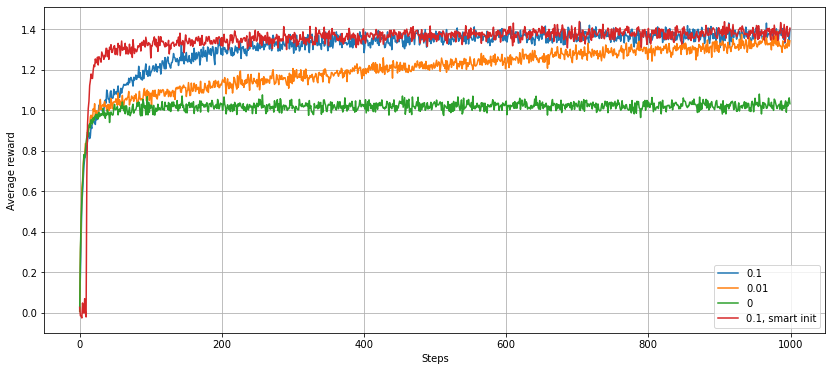

In [22]:
from bandits import epsilon_greedy_performance

plt.plot(epsilon_greedy_performance(arm_mean=0, arm_std=1, epsilon=0.1), label='0.1')
plt.plot(epsilon_greedy_performance(arm_mean=0, arm_std=1, epsilon=0.01), label='0.01')
plt.plot(epsilon_greedy_performance(arm_mean=0, arm_std=1, epsilon=0), label='0')
plt.plot(epsilon_greedy_performance(arm_mean=0, arm_std=1, epsilon=0.1, initialisation=1e10), label='0.1, smart init')
plt.legend()
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Average reward')
#plt.show()
plt.savefig('eps_greedy_comparison.png')

From this plot, we can observe that:
- The strategy with $\varepsilon=0$ (i.e. no exploration) has an average reward that converges to a sub-optimal value, as the strategy fails to find the optimal arm in all experiments - it sometimes settles on another arm giving a positive reward too soon.
- The strategy with a smaller $\varepsilon$ takes longer to converge, as experiments where a sub-optimal arm is favoured early on take longer to pick the optimal one by chance. In the long run though, the smaller $\varepsilon$ strategy will give a better performance, as after settling on the optimal arm it will spend less time retrying alternative, less lucrative arms.
- Initialising the value function to a large positive number ('smart init' in the plot) gives a better performance at the start of the experiments by forcing exploration of all of the arms. The advantage diminishes over time as all the arms are eventually pulled multiple times.    

### UCB action selection

The way that exploration is undertaken by a $\varepsilon$-greedy strategy is quite crude. When the algorithm decides to pick a non-greedy action, it does so at random - all arms are equally likely to be picked, regardless of the information about each of them that is already known. A more sensible method would be to prioritise the arms that either:

 - give the largest estimated rewards, so that it becomes easier to discriminate between the contenders for highest value arm; or,
 - have the largest amount of uncertainty. Arms which have been pulled fewer times give a larger potential for high rewards - maybe the few times the arm has been pulled so far gave unlucky results?

In order to achieve this, we can add an additional term to the action selection equation:

$$A_{t}^{UCB}=argmax_{a\in\{1,2,...,N\}}\left(Q_{t}(a) + c\sqrt{\frac{\log(t)}{N_{t}(a)}}\right)$$

The choice of additional term is motivated by the Hoeffding inequality (see e.g. [here](https://courses.cs.washington.edu/courses/cse599i/18wi/resources/lecture3/lecture3.pdf) for how this bound is derived). The presence of the $N_{t}$ in the demominator allows arms which have not been pulled many times to be prioritised over other, currently more promising arms, in order to aid exploration. We can perform a similar anaysis to before:

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:41<00:00, 71.80it/s]


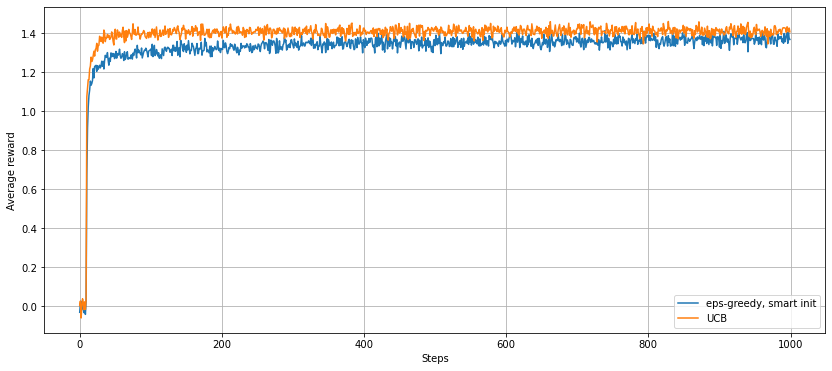

In [24]:
from bandits import ucb_performance

plt.plot(epsilon_greedy_performance(arm_mean=0, arm_std=1, epsilon=0.1, initialisation=1e10), label='eps-greedy, smart init')
plt.plot(ucb_performance(arm_mean=0, arm_std=1, c=0.01), label='UCB')
plt.legend()
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Average reward')
#plt.show()
plt.savefig('ucb_comparison.png')

This plot compares the behaviour of a $\varepsilon$-greedy strategy (with $\varepsilon=0.1$ and smart initialisation) with a UCB strategy:
- In the first few steps, the UCB strategy explores the arms in a similar way to the $\varepsilon$-greedy strategy. The additional term in the optimisation function becomes infinite when $N_{t}(a)=0$, so the UCB algorithm must try all of the arms at least once in order to remove these infinite values. Even after these first steps, the algorithm incentivises the exploration of each arm multiple times, allowing the optimal arm to be found much quicker.
- In the long run, the average reward for the UCB strategy is higher than for the $\varepsilon$-greedy strategy. Rather than arms being chosen at random when exploring, an arm is more likely to be chosen if it has a large value already (i.e. is close to optimal), so these exploratory pulls will give a larger reward on average.

### Gradient bandit algorithm

Although UCB is an improvement on $\varepsilon$-greedy, it still relies on forming an approximation to the value of each arm, and then choosing an action which maximises this. Alternatively, we can assign probabilities to each arm directly, with the action taken at each step decided by sampling from this discrete distribution. This is done using a _preference function_ $H_{t}(a)$, with the probabilities computed using a softmax distribution:

$$P\left(A_{t}=a\right) = \frac{e^{H_{t}(a)}}{\sum_{b=1}^{N}e^{H_{t}(a)}}.$$

But how is the preference function $H_{t}(a)$ determined? Start by setting $H_{t}(a) = 0$ for all $a$, meaning all actions are equally likely at the start. Then, the update rule for $H_{t}(a)$ is calculated using stochastic gradient descent on the expected reward $E(R_{t})$ (see pages 38-40 of [Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) for a derivation). An advantage of this method is that the probabilities assigned to each arm can be tracked over time, giving an indication of what arms the algorithm considers to be the most promising at any particular moment.

Let's look at the gradient bandit algorithm in an example:

In [25]:
np.random.seed(4)
bandit = bandits.GradientBandit(10, 1, 10, 0.1)

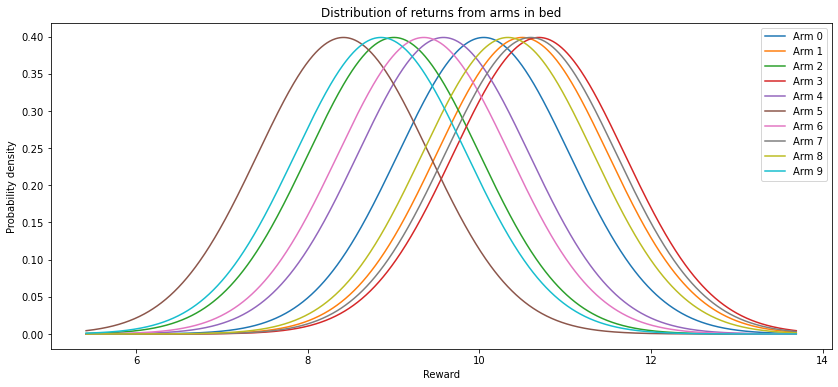

In [26]:
bandit.plot_bed()
plt.savefig('grad_bed.png')

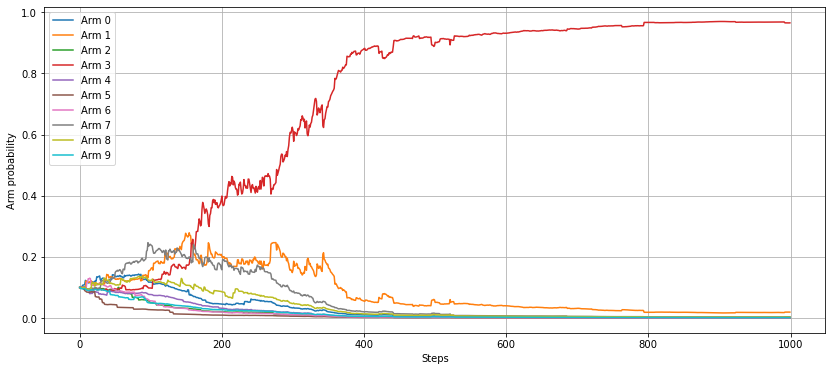

In [27]:
probs = []
for _ in range(1000):
    probs.append(bandit.compute_probs())
    bandit.select_arm()
    
plt.plot(np.array(probs))
plt.legend([f'Arm {i}' for i in range(bandit.num_arms)])
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Arm probability')
#plt.show()
plt.savefig('grad_probs.png')

In this example, we see from the probability distributions of each arm that arms 1, 3 and 7 are hard to distinguish, so will require extensive exploration before settling on the best candidate. This plays out in the arm selection probabilities: at the start, all the arms are approximately equally likely to be pulled, with obvious no-hopers dying away quickly. After 200 steps, the algorithm has identified arm 3 as the best arm, but still only assigns it a 40% chance of being pulled, with arms 1 and 7 given a 20% chance each. As the number of steps increases, the probability of pulling arm 3 continues to increase as the algorithm becomes more confident. Even when another arm is pulled, it is highly likely to be one of the near-optimal arms, meaning the average reward at the latter stages is expected to be quite high.

We can see this by doing another comparison over many runs, this time against the UCB algorithm:

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:41<00:00, 72.40it/s]


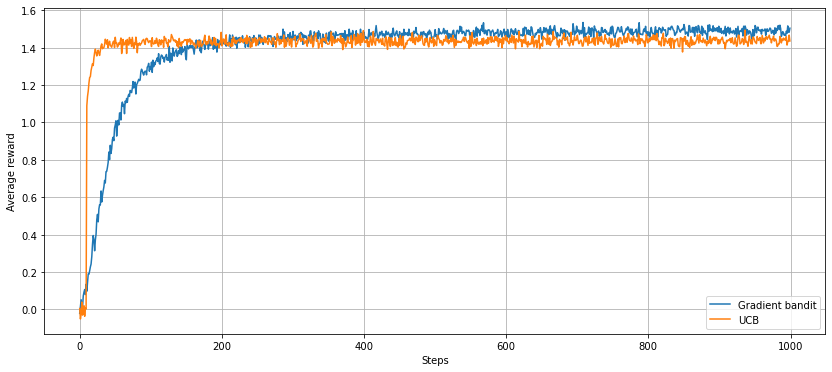

In [28]:
from bandits import grad_bandit_performance

plt.plot(grad_bandit_performance(arm_mean=0, arm_std=1, alpha=0.2), label='Gradient bandit')
plt.plot(ucb_performance(arm_mean=0, arm_std=1, c=0.01), label='UCB')
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
#plt.show()
plt.savefig('grad_comparison.png')

Although the gradient bandit algorithm takes longer to find the optimal arm, once it has it settles on a higher average reward than the UCB strategy, due to the prioritisation of near-optimal arms according to the arm-pull probabilities.

### Keeping up with a changing environment

Suppose now that instead of each arm having a fixed distribution of returns, the distribution changes over time. In particular, suppose that the mean of each arm $\mu_{i}$ behaves like an Ornstein-Uhlenbeck process:

$$\mu_{i}^{(k+1)} = \kappa_{i}\left(\theta_{i}-\mu_i^{(k)}\right) + \sigma_{i}\varepsilon_{i}^{(k)}$$

where $\mu_{i}^{(k)}$ is the mean of the $i$th arm after the $k$th pull (of any arm), and $\{\varepsilon_{i}^{(k)}\}$ are iid standard normal random variables. Under these dynamics, the means exhibit mean reversion behaviour to the 'centres' $\theta_{i}$, with mean reversion speed controlled by $\kappa_{i}$, and a volatility term with magnitude $\sigma_{i}$. In theory each these parameters will be distinct for each arm, but for now consider the case that $\kappa_{i} = \kappa$ and $\sigma_{i}=\sigma$ for all $i$, so that the mean reversion behaviour is the same for all arms. However, the arms will be assumed to have different centre values $\theta_{i}$.

Consider using an epsilon greedy strategy to find the optimal arm in this setup. The value function update rule used in the stationary case uses the mean return obtained from the arm to approximate the value of the arm; this weights the first pulls as much as the most recent pulls, which is fine when the distribution of rewards is constant but problematic when changing over time. Thankfully, a simple change to the update rule can solve this problem:

$$Q_{t+1}(a) = Q_{t}(a) + \alpha(R_{t} - Q_{t}(a))$$

where $\alpha$ is a constant. This has the effect of using an exponential recency-weighted average to approximate the value function, with exponential weight determined by $\alpha$.

Here we define an arm bed with Ornstein-Uhlenbeck arms, with centres all equal to 5, reversion parameters of 0.001, and volatilities of 0.1. We can plot the behaviour of the arms over the first 1000 steps - note that the arms exhibit mean reverting behaviour back to these centre values:

In [29]:
ns_bandit = bandits.EpsGreedyBandit(5, 0, 10, 0.1, 10e8, alpha=0.1, reversion_speeds=0.001*np.ones(10), volatilities=0.1*np.ones(10))

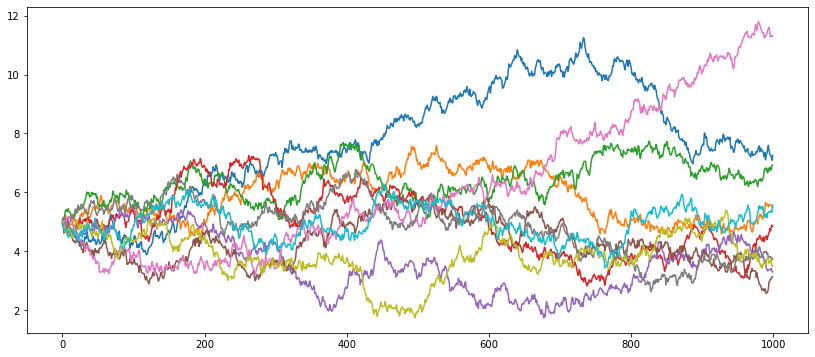

In [30]:
m = []
for i in range(1000):
    ns_bandit.select_arm()
    m.append([arm.mean for arm in ns_bandit.arms])
plt.plot(m)
#plt.show()
plt.savefig('nonstat_evolution.png')

The value of $\alpha$ determines how quickly previously obtained rewards are forgotten, so the optimal value will in general depend on the dynamics of the process itself. In this case, this is controlled by the mean reversion and volatility parameters. Experimenting with a few possible choices for $\alpha$ illustrates this:

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:32<00:00,  9.03it/s]


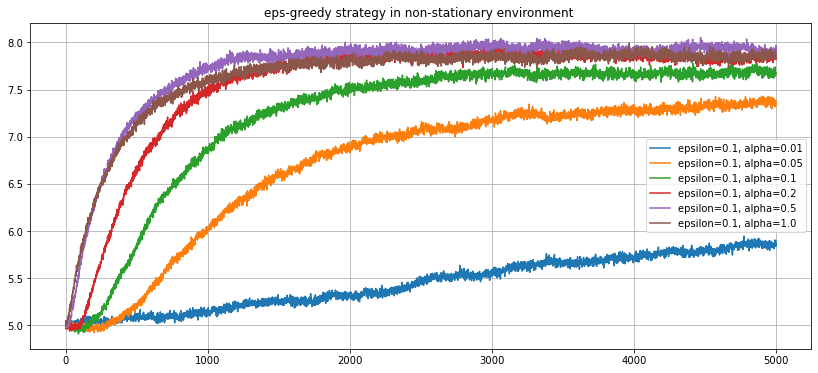

In [32]:
for epsilon in [0.1]:
    for alpha in [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]:
        plt.plot(epsilon_greedy_performance(arm_mean=5, arm_std=0, epsilon=epsilon, alpha=alpha, steps_per_run=5000, reversion_speeds=0.001*np.ones(10), volatilities=0.1*np.ones(10)), label=f'epsilon={epsilon}, alpha={alpha}')
plt.title('eps-greedy strategy in non-stationary environment ')
plt.grid()
plt.legend()
plt.savefig('eps_greedy_nonstat.png')

In this case, choosing $\alpha=0.5$ seems to lead to an average reward of around 8, significantly higher than the expected arm values of 5. The gradient bandit algorithm also relies on a parameter $\alpha$, so should be able handle a non-stationary arm bed too:

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:09<00:00,  1.82it/s]


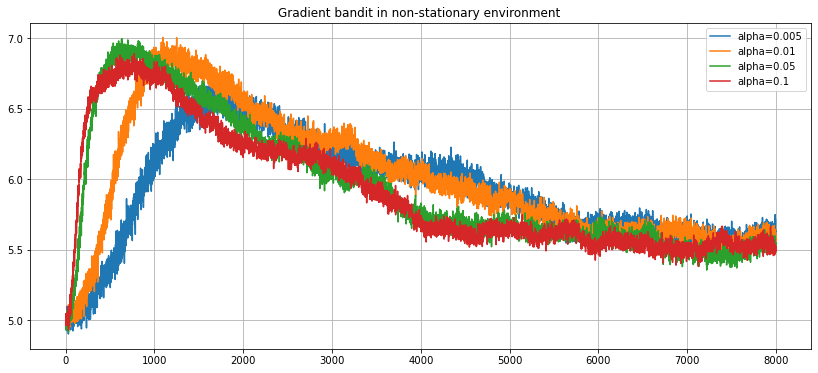

In [227]:
for alpha in [0.005, 0.01, 0.05, 0.1]:
    plt.plot(grad_bandit_performance(arm_mean=5, arm_std=0, alpha=alpha, steps_per_run=8000, num_runs=1000, reversion_speeds=0.001*np.ones(10), volatilities=0.1*np.ones(10)), label=f'alpha={alpha}')
plt.title('Gradient bandit in non-stationary environment ')
plt.grid()
plt.legend()
plt.savefig('grad_nonstat.png')

It seems that although the algorithm learns a good arm early on, it fails to forget the arm quickly enough when it becomes sub-optimal. The reason for this is unclear at the moment - I will make another post in the future exploring this further.

### Summary

In this simple setup with a bed of Gaussian arms with stationary returns, the best strategy in the long run is a gradient based one, where a model of the likelihood of each arm at each time step is maintained. The advantage of having this model is that even when the current best candidate is not being exploited and the algorithm is exploring the alternative arms, the exploration can be done in a systematic way. Also, by looking at the probabilities implied by the value function, we get a more intuitive picture of which arms are more promising than others.

For the non-stationary case, $\varepsilon$-greedy strategies hold up well; comparisons with the other methods will be saved for a future post.